<a href="https://colab.research.google.com/github/MohamedElsayed002/DeepLearning_Study/blob/master/RegularizationTech15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regularization Techinques

In this lab you will learn five regularizaation techniques that are commonly used in trainnig neural networks. you will see how they are implemented using keras and the result of applying each of them on a real world dataset

## Table of Contents

<ol>
    <li><a href="https://#Objectives">Objectives</a></li>
    <li>
        <a href="https://#Setup">Setup</a>
        <ol>
            <li><a href="#Installing-Required-Libraries">Installing Required Libraries</a></li>
            <li><a href="#Importing-Required-Libraries">Importing Required Libraries</a></li>
            <li><a href="#Defining-Helper-Functions">Defining Helper Functions</a></li>
        </ol>     
    </li>
    <li><a href="https://#Overfitting">Overfitting</a></li>
    <li><a href="https://#L2-Regularization">L2 Regularization</a></li>
    <li><a href="https://#L1-Regularization">L1 Regularization</a></li>
    <li><a href="https://#Dropout">Dropout</a></li>
    <li><a href="https://#Batch-Normalization">Batch Normalization</a></li>
    <li><a href="#Example 1: Apply regularization techniques on simulated data">Example 1: Apply regularization techniques on simulated data</a></li>
    <li><a href="#Example 2: Spam Classification">Example 2: Spam Classification</a></li>
</ol>

## Objectives

After completing this lab you will be able to:

*   Understand how the regularization techniques (L1, L2, Dropout, BatchNorm) work for neural networks.
*   Describe the difference between L1 and L2 regularization.
*   Apply the four types of regularization when training neural networks.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Dense

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Defing Heloper Functions

this function helps prepare the SMS spam dataset

In [ ]:
def prepare_data():
    try:
        data = pd.read_csv("spam.csv", encoding='latin-1')
    except FileNotFoundError:
        print("Data file not found, make sure it's downloaded.")

    data.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis=1, inplace=True)
    data.rename(columns={"v1": "label", "v2": "text"}, inplace=True)
    data.label = data['label'].map({'ham':0, 'spam':1})
    data['Count'] = data['text'].apply(lambda x: len(x))

    sw=stopwords.words("english")
    vectorizer = TfidfVectorizer(stop_words=sw, binary=True)

    X = vectorizer.fit_transform(data.text).toarray()
    y = data.label

    return X, y

This function plots the loss and accuracy curve from the training history of neural network

In [ ]:
def plot_metrics(history):
  fig = plt.figure(figsize=(10,5))
  for i , metric in enumerate(['accuracy','loss']):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1,len(train_metrics)+1)
    plt.subplot(1,2,i+1)
    plt.plot(epochs,train_metrics)
    plt.plot(epochs,val_metrics)
    plt.title('Training and validation' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])


# Overfitting

 In the following figure, we see a two-class classification problem. The red points represent one class, and the blue points represent the second class. The actual decision boundary is shown in black. Most points are in the correct region, but several samples are in the incorrect region; this could be for many reasons, such as noise or outliers. The key point is that you do not expect data points of these classes in these regions.

The second model in green is meant to approximate the decision boundary; this model classifies the data points, even the data points in the incorrect regions. This model does not generalize well. This is because most data points will not be in those regions. As a result, the data will do poorly on data not from the original dataset, like data in the real world. This is called **overfitting**.

<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module1/L3/images/Overfitting.png" width="40%"></center>

<p style="text-align:center">
    <a href="https://en.wikipedia.org/wiki/Overfitting?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01">Source: Wikipedia</a>
</p>

To combat overfitting or high variance, we introduce four regularization techniques in this lab for you to choose from the next time you train your neural network. They are:

- L2 (Ridge) regularization
- L1 (Lasso) regularization
- Dropout
- Batch Normalization
- Data shuffling

# L2 Regularization

L2 regularization is perhaps the most common form of regularization analogous to the penalty term in  **Ridge regression**. It penalizes the squared magnitude of the weights $\boldsymbol w$ by adding the term $\frac12 \lambda w^2$ to the objective function that the algorithm is trying to optimize. $\lambda$ is the regularization strength, also called the **shrinkage parameter** which can be tuned during training.

The regularization term is defined as the Euclidean norm of the weight matrices, which sums over all the squared weights. It is multiplied by $\frac12$ so that when the gradient is calculated we get $\lambda w$.

As the shrinkage parameter approaches infinity, the weights are driven down to near zero but **will not be exactly zero**.


# Using L2 Regularization in Keras

In keras, regularization penalties are applied on a per-layer basis that is, you specify the name of the regularizer API as you add a layer to the network. the `tf.keras.regularizers` module has a build-in L2 class that you can call using the following

In [ ]:
tf.keras.regularizers.l2(l=0.01)

This object can be passed as an argument to a Dense Layer

In [ ]:
dense_layer = Dense(32,
                    activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01))

# L1 Regularization

L1 regularization is another common form of regularization. It penalizes large weights $\boldsymbol w$ by adding the term $\lambda |w|$ to the objective function, where $\lambda$ is the regularization strength.

What differentiates L1 from L2 is that, when $\lambda$ approaches infinity, L1 regularization can shrink the weights of the less important features to zero, which would be very useful if you also want automatic feature selection during training.

<p style='color: blue'>The following figure illustrates how L1 and L2 work differently:</p>

<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module1/L3/images/L12_1.png" width="65%"></center>

<p style="text-align:center; color:gray">Source: An Introduction to Statistical Learning</p>


L1 regularization is another common form of regularization. It penalizes large weights $\boldsymbol w$ by adding the term $\lambda |w|$ to the objective function, where $\lambda$ is the regularization strength.

What differentiates L1 from L2 is that, when $\lambda$ approaches infinity, L1 regularization can shrink the weights of the less important features to zero, which would be very useful if you also want automatic feature selection during training.

<p style='color: blue'>The following figure illustrates how L1 and L2 work differently:</p>

<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module1/L3/images/L12_1.png" width="65%"></center>

<p style="text-align:center; color:gray">Source: An Introduction to Statistical Learning</p>


### Using L1 Regularization in Keras

Similar to how we used L2, `tf.keras.regularizers` module also has a built-in L1 class:


In [ ]:
dense_layer = Dense(32,
                    activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l1(l=0.01))

if you don't need to specify a value for the regularization strength, you can also pass a string value to the `kernel_regularizer` argument

In [ ]:
dense_layer = Dense(32,activation='relu',kernel_regularizer='l1')

# Dropout

During training, Dropout will keep a neuron active with some probability `p` (a hyperparameter), or set it to zero otherwise. this regularization techinque approximates training a large number of different neural networks in parallel

<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module1/L3/images/DO_1.png" width="60%"></center>

Picture from the [Dropout paper](http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01)

Dropout can be interpreted as sampling a neural network within the full neural network and only updating the weights of the sampled network. By doing so, each iteration is using a different model architecture and has a different "view" of the configured layers. This adds noise to the training process and perhaps breaks up situations where network layers co-adapt to correct prior mistakes, making the network more robust.

Note that **Dropout is not used during prediction**.

# Using Dropout in keras

In Keras, Dropout can be applied using the Dropout class from `keras.layers` A dropout rate can be specified when creating the dropout layer, which is the percentage of neurons that will be turned off during one update

In [ ]:
from tensorflow.keras.layers import Dropout

dropout_layer = Dropout(rate=0.2)

## Batch Normalization

Training deep neural networks is complicated, because the distribution of each layer's inputs changes as the weights of the previous layers get updated during back propagation. This can result in the learning algorithm always pursuing a moving target. In the [original paper](https://arxiv.org/abs/1502.03167?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01) of Batch Normalization, the change in the distribution of inputs to layers in the network is referred to as **"internal covariate shift"**. This slows down the training by requiring lower learning rates and careful parameter initialization, making it hard for the model to generalize well. Sometimes, if the training samples are statistically too different from the testing samples, it is considered a covariate shift.

### What is Batch Normalization?

Batch normalization is a technique for training very deep neural networks that normalizes the inputs to a layer for every mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.

**Batch**, or **mini-batch**, is a collection of samples that will be passed through the network at one time for the weights update. **Normalization** is the process of transforming the data to have a mean 0 and a standard deviation 1 (thus follows the standard normal distribution).

In a neural network, batch normalization is achieved through a normalization layer between the fully connected Dense layers, which fixes the means and variances of each layer's inputs. This way, there is not much change in the distribution of each layer input, and the layers in the network can learn from back-propagation simultaneously without having to wait for the previous layers to learn. This accelerates the training process.

<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module1/L3/images/BN_6.png" width="70%"></center>

Image credits to [Ilango Rajagopal](https://medium.com/@ilango100/batch-normalization-speed-up-neural-network-training-245e39a62f85)


### How does Batch Normalization work?

Denote by $\boldsymbol B$ a mini-batch of size $\boldsymbol m$ of the training set, for a layer with **_d_**-dimensional input $x = (x^{(1)},...,x^{(d)})$, each dimension of its input is then normalized as:
$$
\hat{x}_{i}^{k} = \frac {x_i ^{k}-\mu_B^{k}} {\sqrt{{\sigma_B^{k}}^2 +\epsilon}}
$$

where $k \in [1,d]$and $i \in [1,m]$; $\mu_B^{k}$ and ${\sigma_B^{k}}^2$are the **per dimension mean and variance** of $\boldsymbol B$ such that:


$$
\mu_B^{k} = \frac{1}{m} \sum_{i=1}^m x_i^{k}, {\sigma_B^{k}}^2 = \frac{1}{m} \sum_{i=1}^m (x_i^{k}-\mu_B^{k})^2
$$


$\epsilon$ is added in the denominator for numerical stability and is an arbitrarily small constant. The resulting normalized activation $\hat{x}^{k}$ has zero mean and unit variance if $\epsilon$ is not taken into account. To restore the representation power of the network, a transformation step then follows as

$$
y_i^{k} = \gamma^{k} \hat{x}_{i}^{k} +\beta^{k}
$$

where the parameters $\gamma^{k}$ and $\beta^{k}$ are subsequently learned in the optimization process. You can refer to [wikipedia](https://en.wikipedia.org/wiki/Batch_normalization?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01) for more mathematical details of batch normalization.

<p style='color: blue'>What are the benefits of Batch Normalization?</p>

1. It tackles the internal covariate shift issue by always normalizing the input signals, thus accelerating the training of deep neural nets and increasing the generalization power of the networks.
2. It makes the optimization landscape smoother, reducing the magnitude of variations in the gradient and the loss, making the training faster and easier.
3. It acts as a regularizer by introducing random noises, as each minibatch at each layer is normalized using its own mean and standard deviation during training.

### Using Batch Normalization in Keras

In Keras, you can add a Batch Norm layer between the Dense layers by calling `BatchNormalization()` from **keras.layers**. Here is a code example:

In [ ]:
from tensorflow.keras.layers import Dense, BatchNormalization

batchnorm_layer = BatchNormalization()

## Example 1: Apply regularization techniques on simulated data

In this example, we will use the **generate_data** function to simulate a degree-3 polynomial dataset with some random noise. We will intentionally overfit the data by creating polynomial features of the data, and then we will observe whether the four regularization techniques can mitigate overfitting in this case.

Let's first visualize the polynomial data:

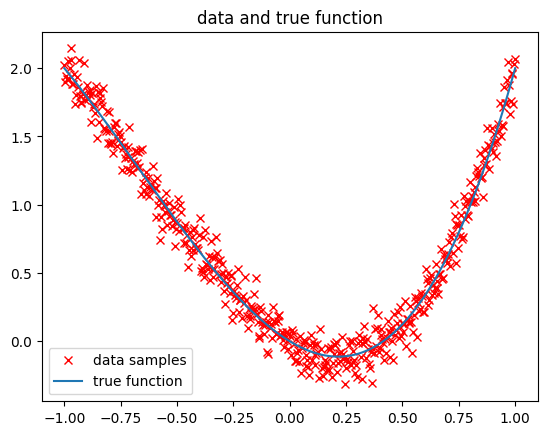

In [ ]:
def generate_data(seed=43,std=0.1,samples=500):
    np.random.seed(seed)
    X =np.linspace(-1,1,samples)
    f = X**3 +2*X**2 -X
    y=f+np.random.randn(samples)*std

    return X, y


X,y = generate_data()
f = X**3 +2*X**2 -X
plt.plot(X, y,'rx',label="data samples")
plt.plot(X, f,label="true function")
plt.title("data and true function")
plt.legend()
plt.show()

let's also add some outlies to y:


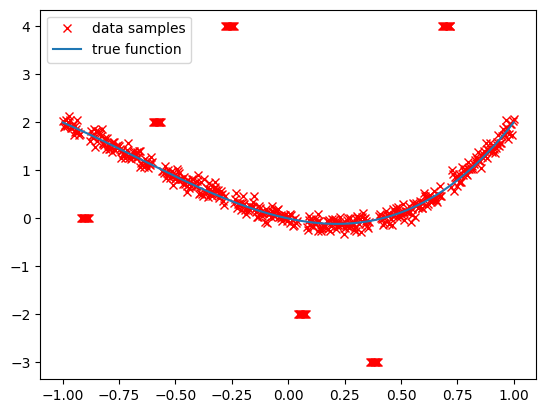

In [ ]:
y[20:30] = 0
y[100:110] = 2
y[180:190] = 4
y[260:270] = -2
y[340:350] = -3
y[420:430] = 4

plt.plot(X, y,'rx',label="data samples")
plt.plot(X, f,label="true function")
plt.legend()
plt.show()

let's use an overly complex neural network to fit our simulated data.

In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Dense(1000,activation='relu',input_shape=(1,)))
model.add(Dense(120,activation='relu'))
model.add(Dense(120,activation='relu'))
model.add(Dense(1))

model.compile(optimizer=Adam(lr=1e-3), loss="mean_squared_error")
model.fit(X, y,  epochs=20, batch_size=100)


Epoch 1/20
5/5 [==============================] - 2s 13ms/step - loss: 1.6274
Epoch 2/20
5/5 [==============================] - 0s 11ms/step - loss: 1.2062
Epoch 3/20
5/5 [==============================] - 0s 9ms/step - loss: 0.9979
Epoch 4/20
5/5 [==============================] - 0s 10ms/step - loss: 0.9987
Epoch 5/20
5/5 [==============================] - 0s 11ms/step - loss: 0.9114
Epoch 6/20
5/5 [==============================] - 0s 7ms/step - loss: 0.9037
Epoch 7/20
5/5 [==============================] - 0s 10ms/step - loss: 0.8698
Epoch 8/20
5/5 [==============================] - 0s 10ms/step - loss: 0.8345
Epoch 9/20
5/5 [==============================] - 0s 8ms/step - loss: 0.8026
Epoch 10/20
5/5 [==============================] - 0s 9ms/step - loss: 0.7856
Epoch 11/20
5/5 [==============================] - 0s 10ms/step - loss: 0.7672
Epoch 12/20
5/5 [==============================] - 0s 7ms/step - loss: 0.7563
Epoch 13/20
5/5 [==============================] - 0s 9ms/step - l

16/16 [==============================] - 0s 2ms/step


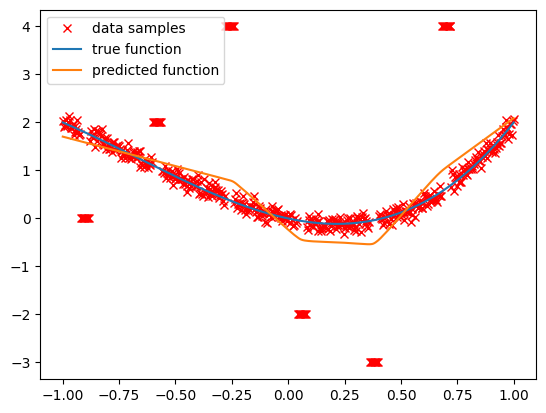

In [ ]:
y_pred = model.predict(X)
plt.plot(X, y,'rx',label="data samples")
plt.plot(X, f,label="true function")
plt.plot(X, y_pred ,label="predicted function")
plt.legend()
plt.show()

we can also calculate the mean square rror

In [ ]:
no_reg = np.mean((y-y_pred)**2)
print(f"Mean squared error is {no_reg}\n")

Mean squared error is 1.9270863140170227



Now let's apply four regularization techniques L1,L2,Dropout and Batch Normalization and see which works best for our data!

# L1 (Lasso)

In [ ]:
model_l1 = Sequential()

model_l1.add(Dense(1000, activation='relu',input_shape=(1,),kernel_regularizer=keras.regularizers.l1(l=0.01)))
model_l1.add(Dense(120,activation='relu',kernel_regularizer=keras.regularizers.l1(l=0.001)))
model_l1.add(Dense(120,activation='relu'))
model_l1.add(Dense(1))
model_l1.compile(optimizer=Adam(lr=1e-3), loss="mean_squared_error")
model_l1.fit(X, y,  epochs=20, batch_size=100)

Epoch 1/20
5/5 [==============================] - 2s 12ms/step - loss: 6.1827
Epoch 2/20
5/5 [==============================] - 0s 11ms/step - loss: 5.3618
Epoch 3/20
5/5 [==============================] - 0s 13ms/step - loss: 4.6874
Epoch 4/20
5/5 [==============================] - 0s 15ms/step - loss: 4.2674
Epoch 5/20
5/5 [==============================] - 0s 14ms/step - loss: 3.7980
Epoch 6/20
5/5 [==============================] - 0s 17ms/step - loss: 3.3965
Epoch 7/20
5/5 [==============================] - 0s 12ms/step - loss: 3.0302
Epoch 8/20
5/5 [==============================] - 0s 12ms/step - loss: 2.6856
Epoch 9/20
5/5 [==============================] - 0s 15ms/step - loss: 2.3843
Epoch 10/20
5/5 [==============================] - 0s 15ms/step - loss: 2.1144
Epoch 11/20
5/5 [==============================] - 0s 15ms/step - loss: 1.8836
Epoch 12/20
5/5 [==============================] - 0s 15ms/step - loss: 1.6881
Epoch 13/20
5/5 [==============================] - 0s 17ms/st

we can plot the model, we see the model tracks the data

16/16 [==============================] - 0s 3ms/step


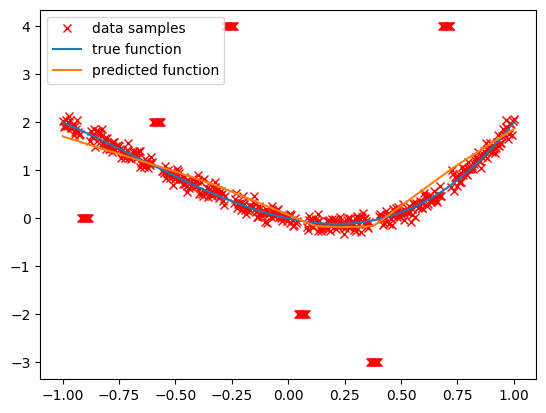

In [ ]:
y_pred = model_l1.predict(X)
plt.plot(X,y,'rx',label='data samples')
plt.plot(X,f,label='true function')
plt.plot(X,y_pred,label='predicted function')
plt.legend()
plt.show()

We can also calculate the mean square error; we see L1 regulation decreases the error:

In [ ]:
l1 = np.mean((y-y_pred)**2)
print(f"Mean squared error is {l1}\n")

Mean squared error is 1.6853154459122601



# L2 (Ridge)

In [ ]:
model_l2 = Sequential()

model_l2.add(Dense(1000, activation='relu',input_shape=(1,),kernel_regularizer=keras.regularizers.l2(l=0.0001)))
model_l2.add(Dense(120,activation='relu',kernel_regularizer=keras.regularizers.l2(l=0.0001)))
model_l2.add(Dense(120,activation='relu',kernel_regularizer=keras.regularizers.l2(l=0.0001)))
model_l2.add(Dense(1))
model_l2.compile(optimizer=Adam(lr=1e-3), loss="mean_squared_error")
model_l2.fit(X, y, validation_split=0.2, epochs=20, batch_size=40)

Epoch 1/20
10/10 [==============================] - 2s 46ms/step - loss: 1.2555 - val_loss: 4.1597
Epoch 2/20
10/10 [==============================] - 0s 14ms/step - loss: 0.7790 - val_loss: 5.3029
Epoch 3/20
10/10 [==============================] - 0s 16ms/step - loss: 0.7574 - val_loss: 4.3505
Epoch 4/20
10/10 [==============================] - 0s 17ms/step - loss: 0.7066 - val_loss: 3.6442
Epoch 5/20
10/10 [==============================] - 0s 16ms/step - loss: 0.7004 - val_loss: 4.1227
Epoch 6/20
10/10 [==============================] - 0s 26ms/step - loss: 0.6934 - val_loss: 4.3712
Epoch 7/20
10/10 [==============================] - 0s 27ms/step - loss: 0.6849 - val_loss: 3.6368
Epoch 8/20
10/10 [==============================] - 0s 30ms/step - loss: 0.6749 - val_loss: 3.5953
Epoch 9/20
10/10 [==============================] - 0s 31ms/step - loss: 0.6718 - val_loss: 3.5090
Epoch 10/20
10/10 [==============================] - 0s 25ms/step - loss: 0.6662 - val_loss: 3.0342
Epoch 11/

We can plot the model, we can also calculate the mean square error; we see L2 regulation can also improve the result by a little bit:

16/16 [==============================] - 0s 3ms/step


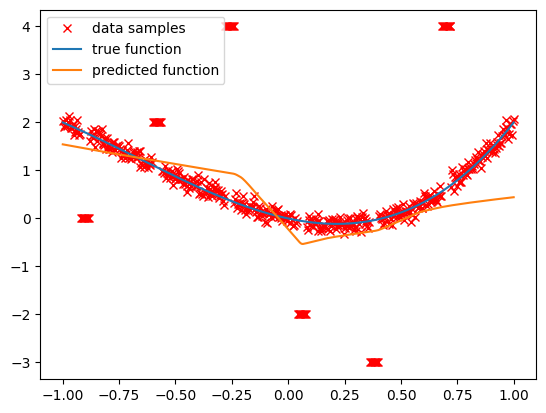

In [ ]:
y_pred = model_l2.predict(X)
plt.plot(X, y,'rx',label="data samples")
plt.plot(X, f,label="true function")
plt.plot(X, y_pred ,label="predicted function")
plt.legend()

In [ ]:
l2 = np.mean((y-y_pred)**2)
print(f"Mean squared error is {l2}\n")

Mean squared error is 1.75933264667604



# Dropout


In [ ]:
model_dp = Sequential()

model_dp.add(Dense(1000,activation='relu',input_shape=(1,)))
model_dp.add(Dropout(0.1))
model_dp.add(Dense(120,activation='relu'))
model_dp.add(Dropout(0.1))
model_dp.add(Dense(120,activation='relu'))
model_dp.add(Dropout(0.1))
model_dp.add(Dense(1))
model_dp.compile(optimizer=Adam(lr=1e-3), loss="mean_squared_error")
model_dp.fit(X, y, validation_split=0.2, epochs=20, batch_size=40)


Epoch 1/20
10/10 [==============================] - 2s 45ms/step - loss: 1.1776 - val_loss: 4.1296
Epoch 2/20
10/10 [==============================] - 0s 16ms/step - loss: 0.7336 - val_loss: 5.3238
Epoch 3/20
10/10 [==============================] - 0s 14ms/step - loss: 0.7323 - val_loss: 3.7141
Epoch 4/20
10/10 [==============================] - 0s 16ms/step - loss: 0.6984 - val_loss: 4.2849
Epoch 5/20
10/10 [==============================] - 0s 16ms/step - loss: 0.6866 - val_loss: 4.1986
Epoch 6/20
10/10 [==============================] - 0s 15ms/step - loss: 0.6769 - val_loss: 3.8869
Epoch 7/20
10/10 [==============================] - 0s 15ms/step - loss: 0.6618 - val_loss: 3.4631
Epoch 8/20
10/10 [==============================] - 0s 15ms/step - loss: 0.6650 - val_loss: 3.2875
Epoch 9/20
10/10 [==============================] - 0s 15ms/step - loss: 0.6519 - val_loss: 3.1270
Epoch 10/20
10/10 [==============================] - 0s 16ms/step - loss: 0.6448 - val_loss: 3.0452
Epoch 11/

16/16 [==============================] - 0s 3ms/step


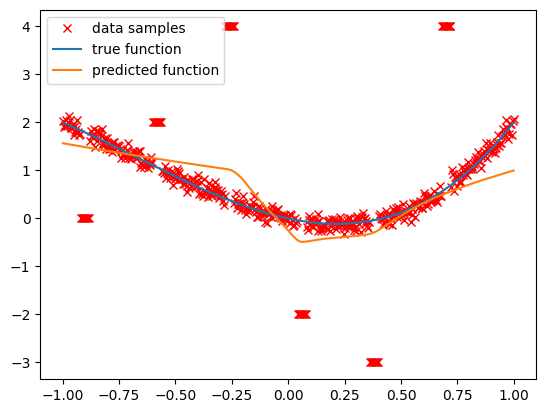

In [ ]:
y_pred = model_dp.predict(X)
plt.plot(X, y,'rx',label="data samples")
plt.plot(X, f,label="true function")
plt.plot(X, y_pred ,label="predicted function")
plt.legend()

In [ ]:
dp = np.mean((y-y_pred)**2)
print(f"Mean squared error is {dp}\n")

Mean squared error is 1.7526663328508418



# Batch Norm

In [ ]:
model_bn = Sequential()

model_bn.add(Dense(1000, activation='relu',input_shape=(1,)))
model_bn.add(BatchNormalization())
model_bn.add(Dense(120,activation='relu'))

model_bn.add(Dense(120,activation='relu'))
model_bn.add(Dense(1))
model_bn.compile(optimizer=Adam(lr=1e-3), loss="mean_squared_error")
model_bn.fit(X, y, validation_split=0.2, epochs=20, batch_size=40)

Epoch 1/20
10/10 [==============================] - 2s 42ms/step - loss: 0.9257 - val_loss: 2.8672
Epoch 2/20
10/10 [==============================] - 0s 15ms/step - loss: 0.6800 - val_loss: 2.8206
Epoch 3/20
10/10 [==============================] - 0s 15ms/step - loss: 0.7087 - val_loss: 2.8028
Epoch 4/20
10/10 [==============================] - 0s 17ms/step - loss: 0.6729 - val_loss: 2.7750
Epoch 5/20
10/10 [==============================] - 0s 19ms/step - loss: 0.7108 - val_loss: 2.7758
Epoch 6/20
10/10 [==============================] - 0s 9ms/step - loss: 0.6856 - val_loss: 2.7547
Epoch 7/20
10/10 [==============================] - 0s 8ms/step - loss: 0.7248 - val_loss: 2.8776
Epoch 8/20
10/10 [==============================] - 0s 9ms/step - loss: 0.7211 - val_loss: 2.8404
Epoch 9/20
10/10 [==============================] - 0s 8ms/step - loss: 0.7375 - val_loss: 2.8750
Epoch 10/20
10/10 [==============================] - 0s 9ms/step - loss: 0.7093 - val_loss: 2.6924
Epoch 11/20
10

We can observe that due to a stronger regularization of Batch Normalization, the model does not seem to fit the data very well. However, the mean square error actually shows a big improvement.

16/16 [==============================] - 0s 3ms/step


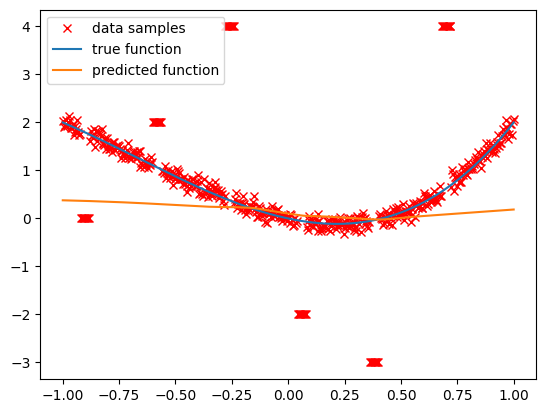

In [ ]:
y_pred = model_bn.predict(X)
plt.plot(X, y,'rx',label="data samples")
plt.plot(X, f,label="true function")
plt.plot(X, y_pred ,label="predicted function")
plt.legend()

In [ ]:
bn = np.mean((y-y_pred)**2)
print(f"Mean squared error is {bn}\n")

Mean squared error is 1.5882893027403395



# Data Shuffling

To apply data shuffling to avoid overfitting we can simpy call `shuffle=True` when fitting the model

In [ ]:
model_sh = Sequential()

model_sh.add(Dense(1000, activation='relu',input_shape=(1,)))
model_sh.add(Dense(120,activation='relu'))
model_sh.add(Dense(120,activation='relu'))
model_sh.add(Dense(1))

model_sh.compile(optimizer=Adam(lr=1e-3), loss="mean_squared_error")
model_sh.fit(X, y, validation_split=0.2, epochs=20, batch_size=40,shuffle=True)

Epoch 1/20
10/10 [==============================] - 2s 48ms/step - loss: 1.2084 - val_loss: 4.2714
Epoch 2/20
10/10 [==============================] - 0s 15ms/step - loss: 0.7168 - val_loss: 5.1639
Epoch 3/20
10/10 [==============================] - 0s 15ms/step - loss: 0.7175 - val_loss: 4.4920
Epoch 4/20
10/10 [==============================] - 0s 18ms/step - loss: 0.6970 - val_loss: 3.6070
Epoch 5/20
10/10 [==============================] - 0s 14ms/step - loss: 0.6760 - val_loss: 4.4317
Epoch 6/20
10/10 [==============================] - 0s 15ms/step - loss: 0.6711 - val_loss: 4.5122
Epoch 7/20
10/10 [==============================] - 0s 14ms/step - loss: 0.6654 - val_loss: 3.7454
Epoch 8/20
10/10 [==============================] - 0s 15ms/step - loss: 0.6563 - val_loss: 3.6997
Epoch 9/20
10/10 [==============================] - 0s 17ms/step - loss: 0.6543 - val_loss: 3.6046
Epoch 10/20
10/10 [==============================] - 0s 15ms/step - loss: 0.6513 - val_loss: 3.4070
Epoch 11/

We can also calculate the mean square error on the data. Data shuffling doesn't seem to be very effective for our data.

16/16 [==============================] - 0s 3ms/step


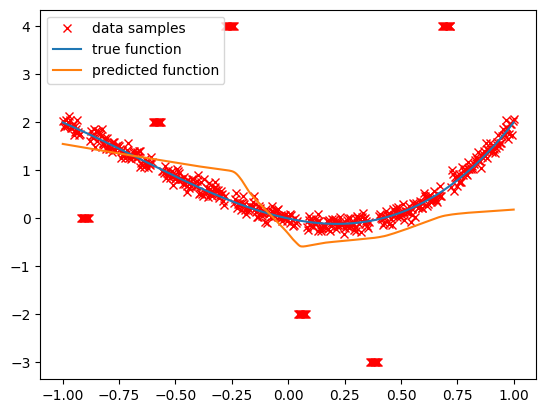

In [ ]:
y_pred = model_sh.predict(X)

plt.plot(X, y,'rx',label="data samples")
plt.plot(X, f,label="true function")
plt.plot(X, y_pred ,label="predicted function")
plt.legend()

In [ ]:
sh = np.mean((y-y_pred)**2)
print(f"Mean squared error is {sh}\n")

Mean squared error is 1.9017859607273502



Let's compare the mean squared errors of the networks trained using different regularization techniques:

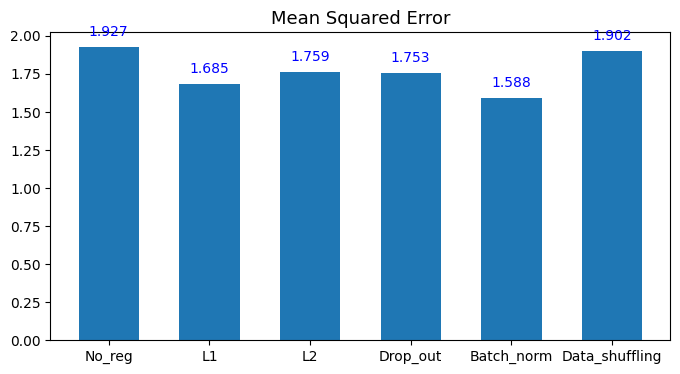

In [ ]:
names = ['No_reg','L1','L2','Drop_out','Batch_norm','Data_shuffling']
error = [no_reg, l1, l2, dp, bn, sh]

plt.figure(figsize=(8, 4))
plt.bar(names, error, width=0.6)
plt.title("Mean Squared Error", fontsize=13)

for i, err in enumerate(error):
    plt.text(i-0.2, err+0.1, str(round(err,3)), color='blue', va='center')

Given the comparison of the mean squared errors, we can conclude that Batch Normalization works best for the simulated dataset. However, one takeaway I hope you to have is that for model training or machine learning in general, there are no cookie-cutter solutions for issues such as overfitting. There are no strict rules as to which technique is most effective when working with one type of dataset, so I would suggest you just try these techniques out and pick the one that you deem is the best (based on an evaluation metric) for your problem!

Now, let's move on to a real world dataset.

# Example 2 : Spam Classification


In this example, we will dive into a real world application, which is a spam classification problem. We will work with the [SMS Spam Collection Dataset](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01) from Kaggle and use neural networks for classifying a message as either Spam or Ham (not spam).

We first download and display the raw dataset:


In [ ]:
import skillsnetwork

await skillsnetwork.download("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module1/L3/data/spam.csv")

Saved as 'spam.csv'


In [ ]:
import skillsnetwork

await skillsnetwork.download("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module1/L3/data/spam.csv")

Saved as 'spam.csv'


In [ ]:
data = pd.read_csv("spam.csv", encoding="latin-1")
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


By calling the helper function **prepare_data**, we obtain a matrix $\boldsymbol X$ which contains the pre-processed text data (mainly using the **TfidfVectorizer** from scikit-learn's **feature_extraction** module) and an object $\boldsymbol y$ which contains the labels of the messages.

There are 5572 text messages that will be classified as either spam **(1)** or non-spam **(0)**, and they are 8536-dimensional data.

In [ ]:
X,y = prepare_data()
X.shape , y.shape

((5572, 8536), (5572,))

### Model Configuration and Training

The **get_model** function provides the layer configuration ane the training of a neural network for different specifications of the regularization technique used. For example, by setting `reg='L1'`, the network's Dense layers will be regularized by L1, and then at the end of the training, the loss and accuracy curve of the train and validation set will be plotted.

In [ ]:
input_dim = X.shape[1]

def get_model(reg=None, epochs=10):
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(input_dim,)))
    if reg=="L1":
        model.add(Dense(256, activation='relu', kernel_regularizer="l1"))
        model.add(Dense(64, activation='relu', kernel_regularizer="l1"))
    elif reg=="L2":
        model.add(Dense(256, activation='relu', kernel_regularizer="l2"))
        model.add(Dense(64, activation='relu', kernel_regularizer="l2"))
    elif reg=="Dropout":
        model.add(Dropout(0.2))
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.2))
    elif reg=="BatchNorm":
        model.add(BatchNormalization())
        model.add(Dense(256, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dense(64, activation='relu'))
        model.add(BatchNormalization())
    else:
        model.add(Dense(256, activation='relu'))
        model.add(Dense(64, activation='relu'))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss="binary_crossentropy", optimizer="adam",
                 metrics=["accuracy"])
    history = model.fit(X, y, batch_size=64, validation_split=0.2,
              epochs=epochs)
    plot_metrics(history)

Baseline No regularization

Epoch 1/10
70/70 [==============================] - 11s 117ms/step - loss: 0.2663 - accuracy: 0.8735 - val_loss: 0.1312 - val_accuracy: 0.9704
Epoch 2/10
70/70 [==============================] - 9s 134ms/step - loss: 0.0527 - accuracy: 0.9939 - val_loss: 0.0659 - val_accuracy: 0.9803
Epoch 3/10
70/70 [==============================] - 6s 82ms/step - loss: 0.0022 - accuracy: 0.9996 - val_loss: 0.0882 - val_accuracy: 0.9812
Epoch 4/10
70/70 [==============================] - 7s 105ms/step - loss: 2.2427e-04 - accuracy: 1.0000 - val_loss: 0.0996 - val_accuracy: 0.9794
Epoch 5/10
70/70 [==============================] - 8s 114ms/step - loss: 1.0148e-04 - accuracy: 1.0000 - val_loss: 0.1056 - val_accuracy: 0.9785
Epoch 6/10
70/70 [==============================] - 10s 146ms/step - loss: 5.9148e-05 - accuracy: 1.0000 - val_loss: 0.1104 - val_accuracy: 0.9785
Epoch 7/10
70/70 [==============================] - 7s 103ms/step - loss: 3.9331e-05 - accuracy: 1.0000 - val_loss: 0.1130 - val_accura

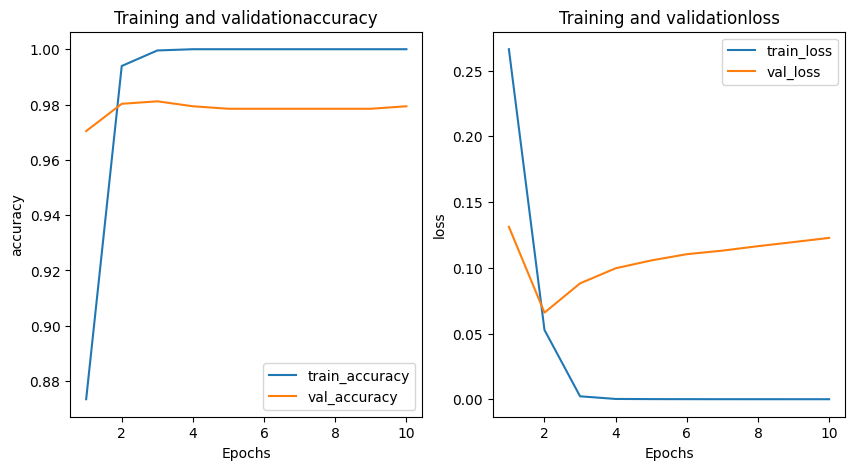

In [ ]:
get_model()

Epoch 1/10
70/70 [==============================] - 13s 164ms/step - loss: 32.2268 - accuracy: 0.8600 - val_loss: 6.4482 - val_accuracy: 0.8700
Epoch 2/10
70/70 [==============================] - 6s 82ms/step - loss: 2.0981 - accuracy: 0.8649 - val_loss: 0.6727 - val_accuracy: 0.8700
Epoch 3/10
70/70 [==============================] - 7s 100ms/step - loss: 0.5998 - accuracy: 0.8649 - val_loss: 0.5667 - val_accuracy: 0.8700
Epoch 4/10
70/70 [==============================] - 6s 80ms/step - loss: 0.5723 - accuracy: 0.8649 - val_loss: 0.5626 - val_accuracy: 0.8700
Epoch 5/10
70/70 [==============================] - 7s 99ms/step - loss: 0.5714 - accuracy: 0.8649 - val_loss: 0.5623 - val_accuracy: 0.8700
Epoch 6/10
70/70 [==============================] - 6s 83ms/step - loss: 0.5712 - accuracy: 0.8649 - val_loss: 0.5617 - val_accuracy: 0.8700
Epoch 7/10
70/70 [==============================] - 7s 99ms/step - loss: 0.5714 - accuracy: 0.8649 - val_loss: 0.5616 - val_accuracy: 0.8700
Epoch 8/1

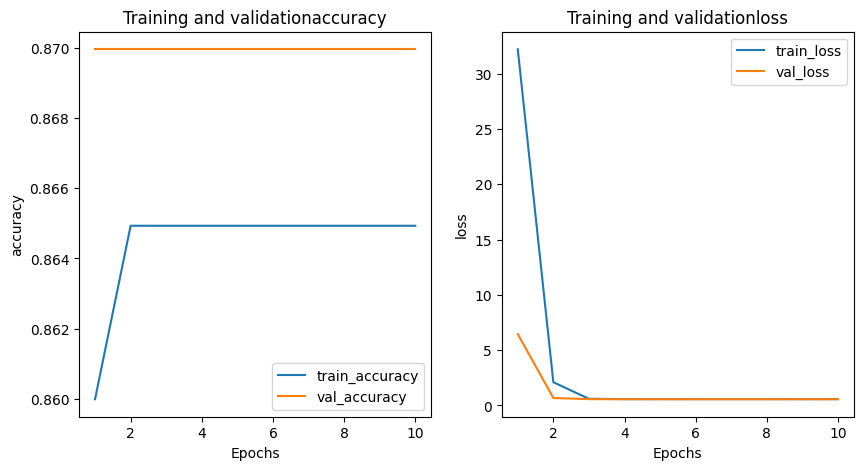

In [ ]:
get_model(reg="L1")

Epoch 1/10
70/70 [==============================] - 7s 90ms/step - loss: 2.0874 - accuracy: 0.8604 - val_loss: 0.5582 - val_accuracy: 0.9067
Epoch 2/10
70/70 [==============================] - 7s 105ms/step - loss: 0.2805 - accuracy: 0.9791 - val_loss: 0.1703 - val_accuracy: 0.9722
Epoch 3/10
70/70 [==============================] - 6s 84ms/step - loss: 0.0981 - accuracy: 0.9960 - val_loss: 0.1237 - val_accuracy: 0.9758
Epoch 4/10
70/70 [==============================] - 7s 107ms/step - loss: 0.0660 - accuracy: 0.9989 - val_loss: 0.1085 - val_accuracy: 0.9776
Epoch 5/10
70/70 [==============================] - 6s 79ms/step - loss: 0.0528 - accuracy: 0.9996 - val_loss: 0.0971 - val_accuracy: 0.9794
Epoch 6/10
70/70 [==============================] - 7s 107ms/step - loss: 0.0448 - accuracy: 0.9996 - val_loss: 0.0921 - val_accuracy: 0.9803
Epoch 7/10
70/70 [==============================] - 6s 91ms/step - loss: 0.0389 - accuracy: 0.9998 - val_loss: 0.0864 - val_accuracy: 0.9821
Epoch 8/10

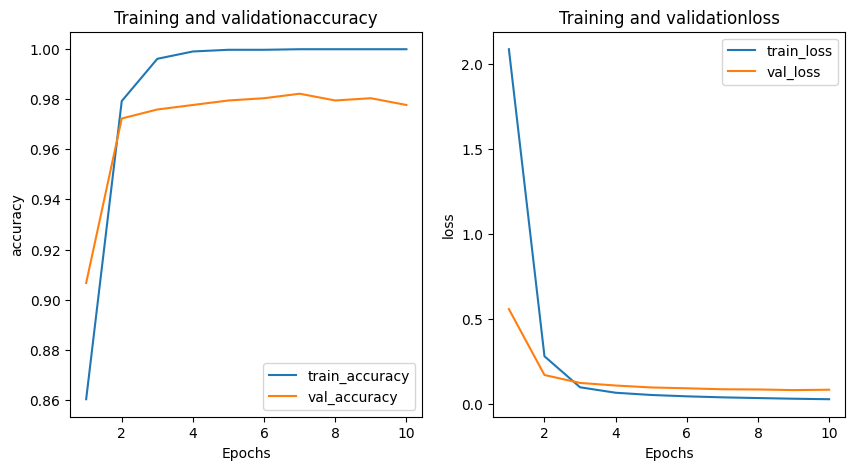

In [ ]:
get_model(reg="L2")

Epoch 1/10
70/70 [==============================] - 8s 101ms/step - loss: 0.2748 - accuracy: 0.8735 - val_loss: 0.1362 - val_accuracy: 0.9677
Epoch 2/10
70/70 [==============================] - 6s 85ms/step - loss: 0.0546 - accuracy: 0.9921 - val_loss: 0.0668 - val_accuracy: 0.9821
Epoch 3/10
70/70 [==============================] - 6s 89ms/step - loss: 0.0029 - accuracy: 0.9996 - val_loss: 0.0876 - val_accuracy: 0.9794
Epoch 4/10
70/70 [==============================] - 7s 95ms/step - loss: 3.8625e-04 - accuracy: 1.0000 - val_loss: 0.1018 - val_accuracy: 0.9785
Epoch 5/10
70/70 [==============================] - 6s 83ms/step - loss: 1.5192e-04 - accuracy: 1.0000 - val_loss: 0.1070 - val_accuracy: 0.9785
Epoch 6/10
70/70 [==============================] - 7s 97ms/step - loss: 9.3749e-05 - accuracy: 1.0000 - val_loss: 0.1117 - val_accuracy: 0.9794
Epoch 7/10
70/70 [==============================] - 6s 80ms/step - loss: 5.4890e-05 - accuracy: 1.0000 - val_loss: 0.1165 - val_accuracy: 0.9

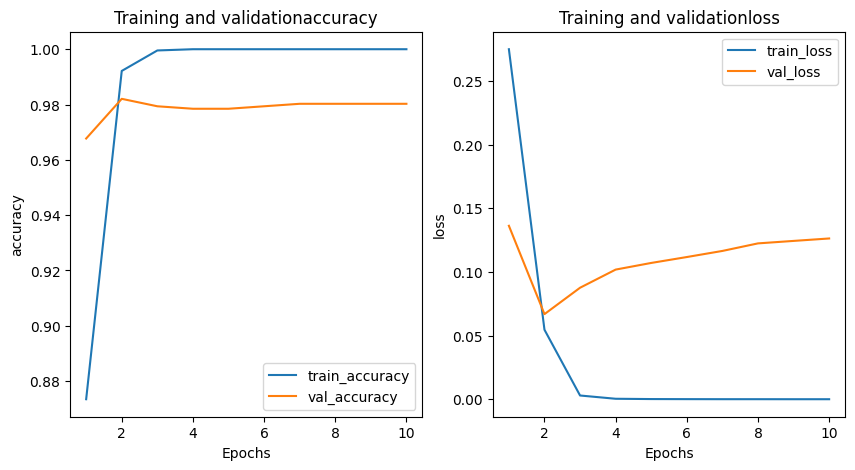

In [ ]:
get_model(reg="Dropout")


Epoch 1/10
70/70 [==============================] - 9s 118ms/step - loss: 0.2784 - accuracy: 0.8613 - val_loss: 0.1337 - val_accuracy: 0.9686
Epoch 2/10
70/70 [==============================] - 6s 82ms/step - loss: 0.0727 - accuracy: 0.9924 - val_loss: 0.0661 - val_accuracy: 0.9821
Epoch 3/10
70/70 [==============================] - 7s 96ms/step - loss: 0.0035 - accuracy: 0.9998 - val_loss: 0.1007 - val_accuracy: 0.9803
Epoch 4/10
70/70 [==============================] - 5s 78ms/step - loss: 4.1511e-04 - accuracy: 1.0000 - val_loss: 0.1067 - val_accuracy: 0.9785
Epoch 5/10
70/70 [==============================] - 7s 97ms/step - loss: 1.3494e-04 - accuracy: 1.0000 - val_loss: 0.1108 - val_accuracy: 0.9785
Epoch 6/10
70/70 [==============================] - 6s 83ms/step - loss: 8.0784e-05 - accuracy: 1.0000 - val_loss: 0.1146 - val_accuracy: 0.9785
Epoch 7/10
70/70 [==============================] - 6s 87ms/step - loss: 5.4634e-05 - accuracy: 1.0000 - val_loss: 0.1184 - val_accuracy: 0.9

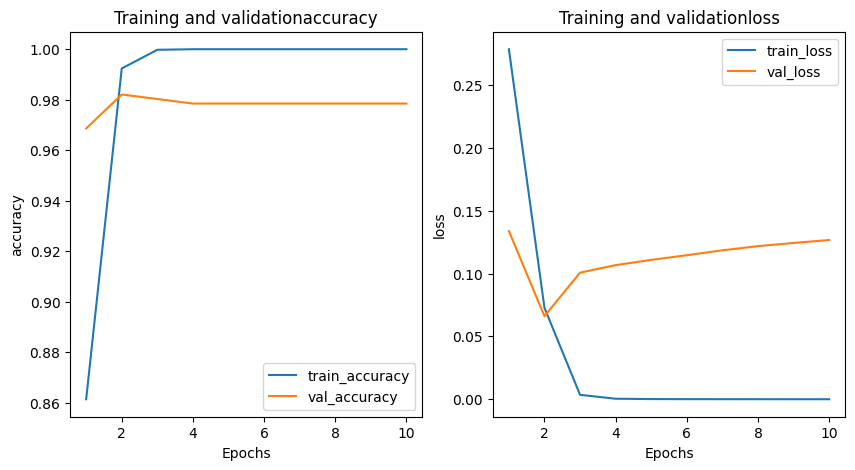

In [ ]:
get_model(reg="BathNorm")